<a href="https://colab.research.google.com/github/Koettinl/IR-TinyML-Messedemo/blob/main/Kopie_von_TinyML_Messedemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Set Environment**


In [29]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# for Data Preparation
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# Tensorflow
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
print(tf.version)

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.7/dist-packages/tensorflow/_api/v2/version/__init__.py'>


### **Data Preparation**

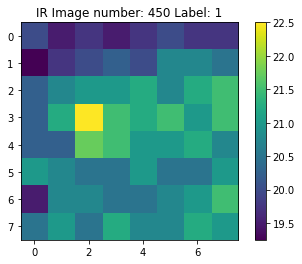

Min:  18.25 °C	Max:  64.0 °C
   19.25  19.75   20.5     20  20.5.1  ...  20.25.2   21.4  20.25.3  21.5.2  21.25.6
0  20.25  20.25  20.50  19.25   20.50  ...    20.50  20.50    19.75   20.75    21.75
1  20.25  20.25  20.75  20.00   20.75  ...    20.50  20.75    20.25   20.75    22.00
2  20.50  20.25  20.00  19.75   20.50  ...    20.75  20.75    20.75   21.50    22.25
3  20.50  20.25  20.50  20.00   20.50  ...    21.00  21.25    20.75   21.50    22.00
4  20.25  19.75  20.50  19.75   20.50  ...    21.00  20.75    20.75   21.25    22.25

[5 rows x 64 columns]
      19.25     19.75      20.5  ...   20.25.3    21.5.2   21.25.6
0  0.043716  0.043716  0.049180  ...  0.032787  0.054645  0.076503
1  0.043716  0.043716  0.054645  ...  0.043716  0.054645  0.081967
2  0.049180  0.043716  0.038251  ...  0.054645  0.071038  0.087432
3  0.049180  0.043716  0.049180  ...  0.054645  0.071038  0.081967
4  0.043716  0.032787  0.049180  ...  0.054645  0.065574  0.087432

[5 rows x 64 columns]


In [23]:
# input data
url = "/content/drive/MyDrive/my_csv.csv"

# read data set
df_raw = pd.read_csv(url, parse_dates=True)
h,w = df_raw.shape

# format date in data set
df_raw.iloc[0:h, 0] = pd.to_datetime(df_raw.iloc[0:h,0])

# Separate labels and date from the Data set
df_label = df_raw.pop(df_raw.columns[w-1])
df = df_raw.iloc[0:h, 1:w-1]

# visualisation
row = 450 #index of image to be shown

img = df.iloc[row,0:w-1]
img = np.array(img, dtype = np.float32 )
size = int(np.sqrt(img.size))
img = img.reshape(size, size)

# plot image
plt.imshow(img)
plt.title('IR Image number: '+str(row)+' Label: '+str(df_label[row]))
plt.colorbar()
plt.show()



# prepare data for NN
min = df.min().min()
max = df.max().max()
df_normalized = (df_raw.iloc[0:h, 1:w-1] - min) / (max - min)

print("Min: ", min,"°C\tMax: ", max, "°C")
print(df.head())
print(df_normalized.head())

In [8]:
# Set training and test data and labels
training_dataset = df_normalized.sample(frac=0.8, random_state=0)
testing_dataset =  df_normalized.drop(training_dataset.index)

# reshape training dataset to a 8x8 np.array
training_h, training_w = training_dataset.shape
training_dataset = np.array(training_dataset, dtype=np.float32)
training_dataset = training_dataset.reshape(training_h, size, size,-1)

# reshape testing dataset to a 8x8 np.array
testing_h, testing_w = testing_dataset.shape
testing_dataset = np.array(testing_dataset, dtype=np.float32)
testing_dataset = testing_dataset.reshape(testing_h, size, size,-1)

# training and test labeling
training_labels = df_label.sample(frac=0.8, random_state=0)
testing_labels =  df_label.drop(training_labels.index)

# **Train the model**

In [10]:
num_clases = 3
batchsize = 32
inputShape = (8,8,1)

model = tf.keras.Sequential()
model.add(layers.Flatten(input_shape = inputShape)) 
model.add(layers.Dense(32, activation = 'sigmoid',input_shape = (64,)))
model.add(layers.Dense(16,activation = 'sigmoid'))
model.add(layers.Dense(num_clases, activation = 'sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 3)                 51        
                                                                 
Total params: 2,659
Trainable params: 2,659
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(
        learning_rate= 0.005,
        momentum=0.9),
        loss = 'categorical_crossentropy',
        metrics = ['accuracy'],)

history = model.fit(training_dataset, 
                    to_categorical(training_labels), 
                    validation_data=(testing_dataset, testing_labels), 
                    validation_split=0.2, epochs = 500, batch_size = batchsize)

Epoch 1/500
108/108 [==============================] - 1s 4ms/step - loss: 1.1194 - accuracy: 0.3747 - val_loss: 1.0793 - val_accuracy: 0.6333
Epoch 2/500
108/108 [==============================] - 0s 2ms/step - loss: 1.0729 - accuracy: 0.4764 - val_loss: 1.0612 - val_accuracy: 0.7707
Epoch 3/500
108/108 [==============================] - 0s 2ms/step - loss: 1.0521 - accuracy: 0.5661 - val_loss: 1.0299 - val_accuracy: 0.6333
Epoch 4/500
108/108 [==============================] - 0s 2ms/step - loss: 1.0251 - accuracy: 0.6664 - val_loss: 0.9965 - val_accuracy: 0.6496
Epoch 5/500
108/108 [==============================] - 0s 2ms/step - loss: 0.9873 - accuracy: 0.6681 - val_loss: 0.9543 - val_accuracy: 0.6764
Epoch 6/500
108/108 [==============================] - 0s 2ms/step - loss: 0.9359 - accuracy: 0.6780 - val_loss: 0.8974 - val_accuracy: 0.7451
Epoch 7/500
108/108 [==============================] - 0s 2ms/step - loss: 0.8744 - accuracy: 0.7043 - val_loss: 0.8302 - val_accuracy: 0.7532

34/34 [==============================] - 0s 1ms/step - loss: 0.0409 - accuracy: 0.9870


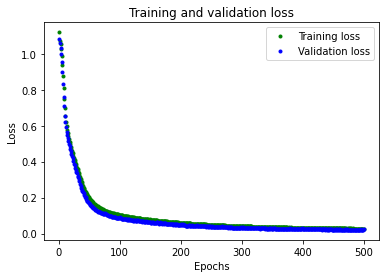

In [12]:
model.evaluate(
    testing_dataset, 
    to_categorical(testing_labels)
)

# Graphing the History
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs= range(1,len(loss)+1)

plt.plot(epochs, loss, 'g.', label= 'Training loss')
plt.plot(epochs, val_loss, 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend() 
plt.show() 

# **Save the NN**

In [13]:
name = "My_Neuronal_Network"
url_h5 = "/content/drive/MyDrive/" + name + ".h5"
url_tflite = '/content/drive/MyDrive/' + name + '.tflite'
# save tensorflow model
model.save(url_h5)

In [14]:
cnn_model = tf.keras.models.load_model(url_h5)
converter = tf.lite.TFLiteConverter.from_keras_model(cnn_model)
tflite_model = converter.convert()
# save tensorflow lite model 
with open(url_tflite, 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp9d7nfm_s/assets


# **Test Tensor Flow Lite model**

Index:  449 Label:  1 Prediction:  0


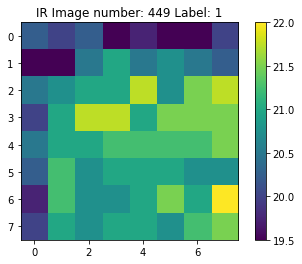

Index:  450 Label:  1 Prediction:  0


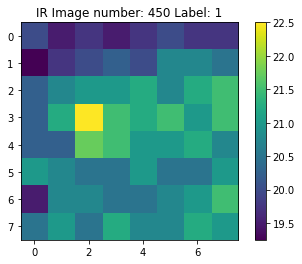

Index:  451 Label:  1 Prediction:  0


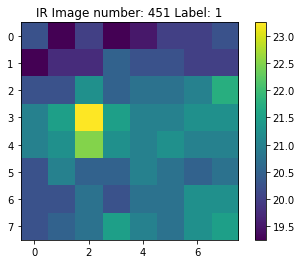

Index:  452 Label:  1 Prediction:  0


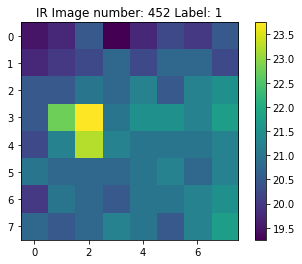

Index:  453 Label:  1 Prediction:  0


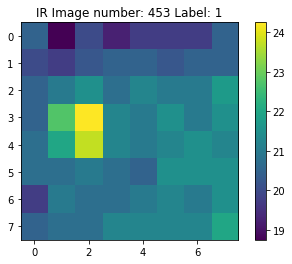

Index:  454 Label:  1 Prediction:  0


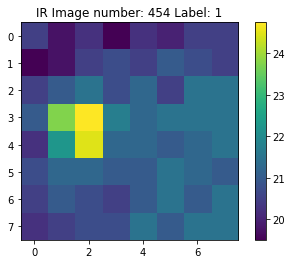

Index:  455 Label:  1 Prediction:  0


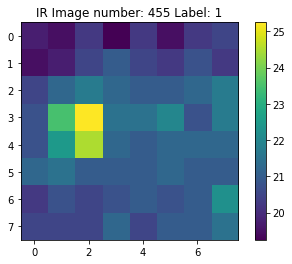

Index:  456 Label:  1 Prediction:  0


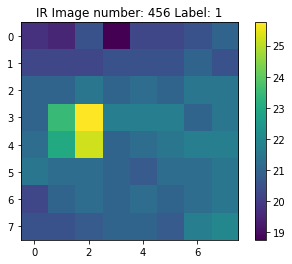

Index:  457 Label:  1 Prediction:  0


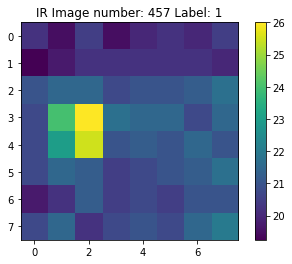

Index:  458 Label:  1 Prediction:  0


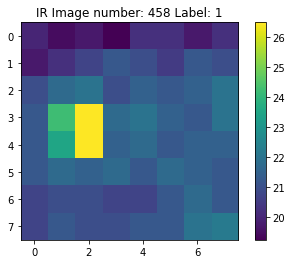

Index:  896 Label:  1 Prediction:  0


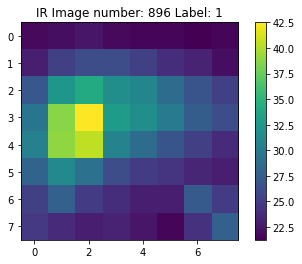

Index:  899 Label:  2 Prediction:  1


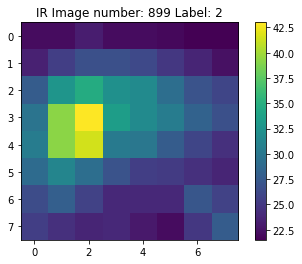

Index:  900 Label:  2 Prediction:  1


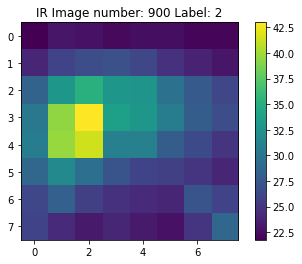

Index:  901 Label:  2 Prediction:  1


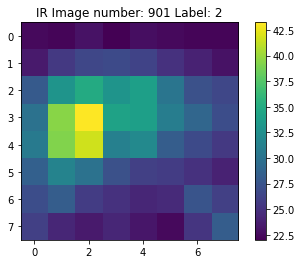

In [26]:
# input data
url = "/content/drive/MyDrive/my_csv.csv"

# read data set
#df_raw = pd.read_csv(url, parse_dates=True)
#h,w = df_raw.shape

# format date in data set
#df_raw.iloc[0:h, 0] = pd.to_datetime(df_raw.iloc[0:h,0])

# Separate labels and date from the Data set
#df_label = df_raw.pop(df_raw.columns[w-1])
#df = df_raw.iloc[0:h, 1:w-1]

#url = "/content/drive/MyDrive/Colab Notebooks/TinyML_IR-Sensor-main/klassifizierung_messedemo.csv"

#num_classes=3
#input = 64 
prediction=[]

# read the csv row wise and classify
for n_read_rows in range(1, 1200):
  df_val = pd.read_csv(url, parse_dates=True, sep=',', skiprows=n_read_rows, nrows=1)
  h, w = df_val.shape

  # separate date and label
  label = df_val.pop(df_val.columns[w-1])
  df_val = df_val.iloc[0:h, 1:w-1]

  # reshape numpy array
  val_data = np.array(df_val, dtype = np.float32 )
  val_data = np.reshape(val_data, (1,8,8,-1))

  # normalize the data
  min = 20.0
  max = 80.0
  val = (val_data - min) / (max - min) 

  # set tflite model
  interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/My_Neuronal_Network.tflite")
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  interpreter.set_tensor(interpreter.get_input_details()[0]["index"], val)
  interpreter.invoke()
  output = interpreter.get_tensor(output_details[0]['index'])

  # prediction
  tfl_prediction = np.argmax(output)
  # list all predictions
  prediction.append((label, tfl_prediction))
  # print if prediction is differs from label
  if (tfl_prediction != label.iloc[0]):
    print("Index: ",n_read_rows, "Label: ", label[0], "Prediction: ", tfl_prediction)

    val_data = np.reshape(val_data, (8,8))
    # plot image
    plt.imshow(val_data)
    plt.title('IR Image number: '+str(n_read_rows)+' Label: '+str(label[0]))
    plt.colorbar()
    plt.show()
